# Loan Prediction System

- The system simplifies the loan approval process by automating real-time eligibility assessments using customer-provided information during online loan applications. Key details include gender, marital status, education, number of dependents, income, loan amount, and credit history.

- In this project, I developed a predictive system to determine customer eligibility for loans based on these factors. Additionally, the system analyzes cases where applicants are ineligible to identify the reasons for rejection, providing insights that improve customer targeting and clarify the factors leading to loan denial.

### Importing Packages

In [251]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, r2_score, mean_squared_error, mean_absolute_error)
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message="A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy")


### Part 1: Gathering Data

In [252]:
df = pd.read_csv("loan_approval_dataset.csv")
df.sample(5)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
1085,1086,5,Not Graduate,Yes,9600000,29600000,4,446,22900000,3500000,36600000,13200000,Approved
3680,3681,5,Not Graduate,No,2700000,5600000,2,815,1100000,2000000,7100000,2600000,Approved
2752,2753,1,Graduate,No,200000,300000,12,697,600000,300000,700000,100000,Approved
821,822,0,Not Graduate,Yes,2000000,5900000,12,900,3800000,2400000,7100000,3000000,Approved
3782,3783,5,Graduate,Yes,9500000,21700000,16,307,27500000,2700000,28500000,9700000,Rejected


### Part 2: Feature Engineering

In [253]:
columns_to_remove = ['loan_id']
df.drop(columns=columns_to_remove, inplace=True)

In [254]:
print("Dataset Shape:", df.shape)

Dataset Shape: (4269, 12)


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0    no_of_dependents          4269 non-null   int64 
 1    education                 4269 non-null   object
 2    self_employed             4269 non-null   object
 3    income_annum              4269 non-null   int64 
 4    loan_amount               4269 non-null   int64 
 5    loan_term                 4269 non-null   int64 
 6    cibil_score               4269 non-null   int64 
 7    residential_assets_value  4269 non-null   int64 
 8    commercial_assets_value   4269 non-null   int64 
 9    luxury_assets_value       4269 non-null   int64 
 10   bank_asset_value          4269 non-null   int64 
 11   loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [256]:
# Movable Assets and Immovable Assets
df['Movable_assets'] = df[' bank_asset_value'] + df[' luxury_assets_value']
df['Immovable_assets'] = df[' residential_assets_value'] + df[' commercial_assets_value']

In [257]:
df.drop(columns=[' bank_asset_value',' luxury_assets_value', ' residential_assets_value', ' commercial_assets_value' ], inplace=True)

In [258]:
def uniquevals(col):
    print(f'Unique Values in {col} is : {df[col].unique()}')

def valuecounts(col):
    print(f'Valuecounts of {col} is: {len(df[col].value_counts())}')

for col in df.columns:
    valuecounts(col)
    print("-"*75)

Valuecounts of  no_of_dependents is: 6
---------------------------------------------------------------------------
Valuecounts of  education is: 2
---------------------------------------------------------------------------
Valuecounts of  self_employed is: 2
---------------------------------------------------------------------------
Valuecounts of  income_annum is: 98
---------------------------------------------------------------------------
Valuecounts of  loan_amount is: 378
---------------------------------------------------------------------------
Valuecounts of  loan_term is: 10
---------------------------------------------------------------------------
Valuecounts of  cibil_score is: 601
---------------------------------------------------------------------------
Valuecounts of  loan_status is: 2
---------------------------------------------------------------------------
Valuecounts of Movable_assets is: 484
------------------------------------------------------------------------

In [259]:
# categorical data and numarical data
catvars = df.select_dtypes(include=['object']).columns
numvars = df.select_dtypes(include = ['int32','int64','float32','float64']).columns

catvars,numvars

(Index([' education', ' self_employed', ' loan_status'], dtype='object'),
 Index([' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term',
        ' cibil_score', 'Movable_assets', 'Immovable_assets'],
       dtype='object'))

### Part 3: Data Cleaning

In [260]:
import missingno as msno
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

<Axes: >

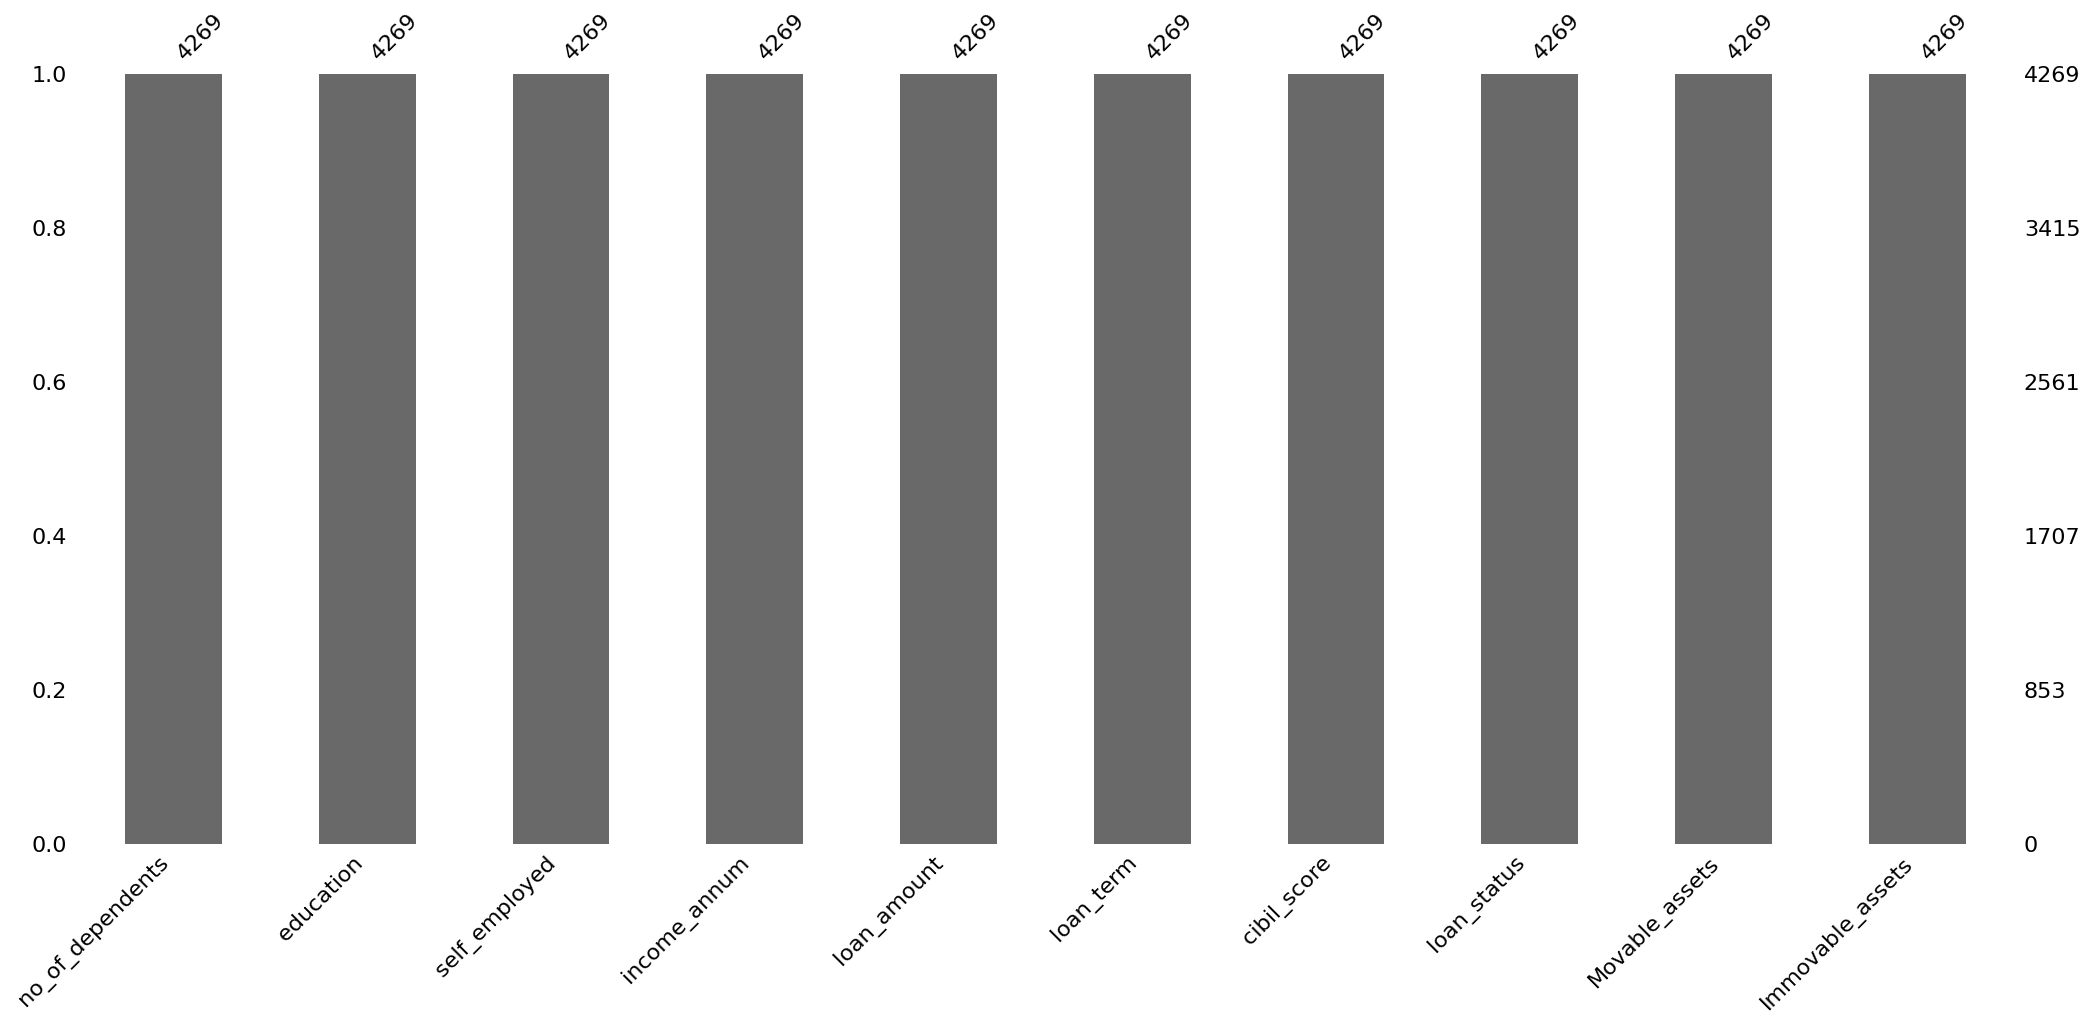

In [261]:
msno.bar(df)

In [262]:
df.isna().sum()

 no_of_dependents    0
 education           0
 self_employed       0
 income_annum        0
 loan_amount         0
 loan_term           0
 cibil_score         0
 loan_status         0
Movable_assets       0
Immovable_assets     0
dtype: int64

In [263]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,Movable_assets,Immovable_assets
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,2.010300e+07,1.244577e+07
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,1.183658e+07,9.232541e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,3.000000e+05,-1.000000e+05
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,1.000000e+07,4.900000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,1.960000e+07,1.060000e+07
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,2.910000e+07,1.820000e+07
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,5.380000e+07,4.660000e+07


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0    no_of_dependents  4269 non-null   int64 
 1    education         4269 non-null   object
 2    self_employed     4269 non-null   object
 3    income_annum      4269 non-null   int64 
 4    loan_amount       4269 non-null   int64 
 5    loan_term         4269 non-null   int64 
 6    cibil_score       4269 non-null   int64 
 7    loan_status       4269 non-null   object
 8   Movable_assets     4269 non-null   int64 
 9   Immovable_assets   4269 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 333.6+ KB


### Part 4: Exploratory Data Analysis

In [265]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

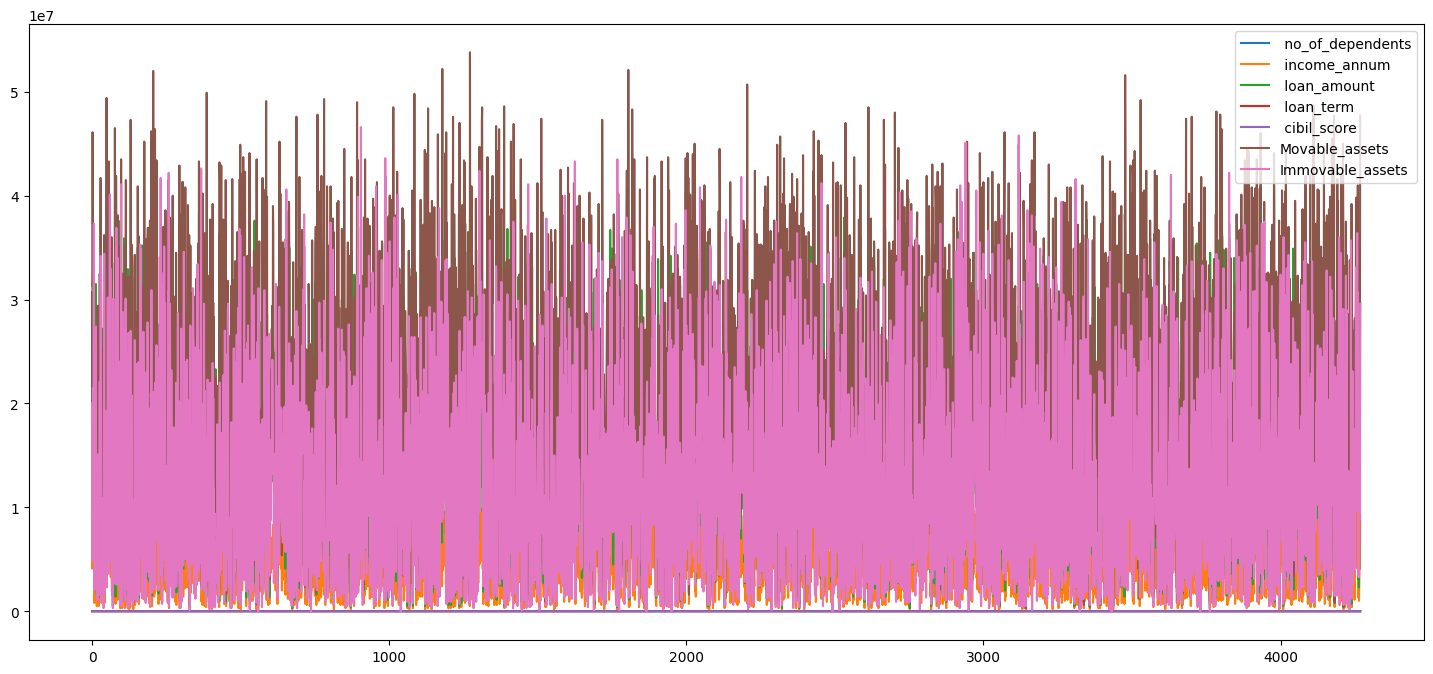

In [266]:
df.plot(figsize=(18, 8))
plt.show()

#### Number Of Dependents Distribution

Text(0.5, 1.0, 'Number of Dependents')

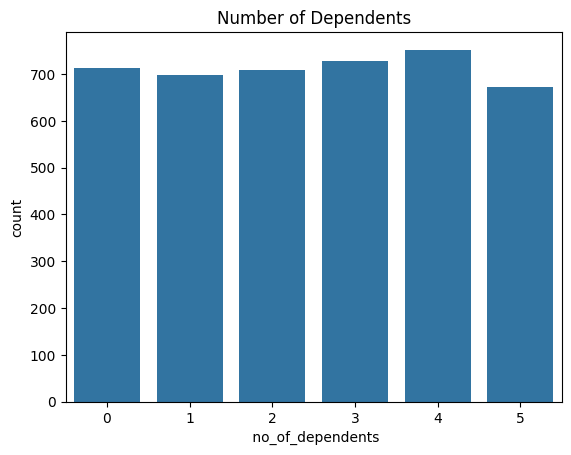

In [267]:
sns.countplot(x = ' no_of_dependents', data = df).set_title('Number of Dependents')

- The graph highlights the number of dependents among loan applicants, showing a clear difference in living arrangements. 
- The variation in the number of dependents isn't substantial, but as the number of dependents rises, the applicant's disposable income decreases. 
- Therefore, it's likely that applicants with 0 or 1 dependent have a higher chance of loan approval.

#### Number of Dependants Vs Loan Status

<Axes: xlabel=' no_of_dependents', ylabel='count'>

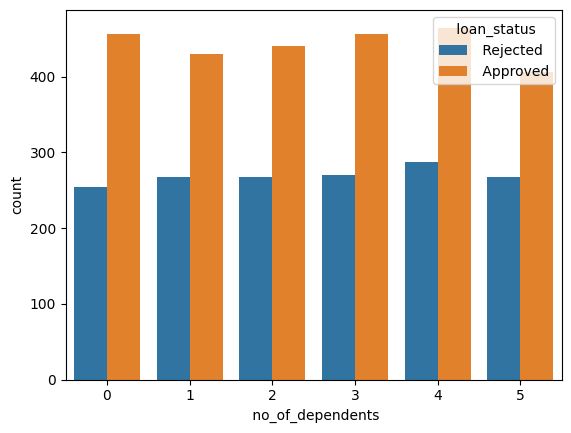

In [268]:
sns.countplot(x = ' no_of_dependents', data = df, hue = ' loan_status')

- The graph shows that as the number of dependents a person has increases, their chances of loan rejection tend to rise. 
- However, what's surprising is that the approval rate doesn't vary much, regardless of how many family members they support. 
- This suggests that my assumption—that applicants with more dependents would be less likely to get approved—may not be accurate based on this data. 
- It highlights that our expectations don't always align with real outcomes.

#### Education and Self Employed

Text(0.5, 1.0, 'Self Employed')

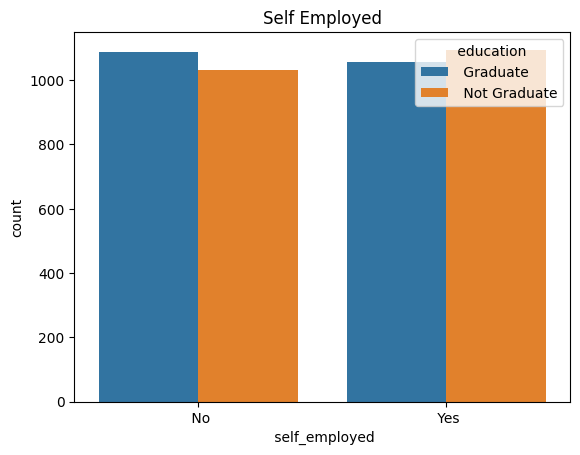

In [269]:
sns.countplot(x=' self_employed', data = df, hue = ' education').set_title('Self Employed')

- The graph illustrating the relationship between applicants' employment status and their education levels reveals significant trends relevant to loan approval. It shows that most non-graduate applicants are self-employed, while the majority of graduate applicants hold salaried positions. This suggests that graduates tend to have more stable employment, which may provide a more reliable income source for loan repayment. In contrast, non-graduates who are self-employed may experience income fluctuations, making it challenging to ensure consistent loan payments.

- However, it’s worth noting that self-employed non-graduates could potentially earn higher incomes, which might mitigate concerns about income volatility. Thus, understanding the interaction between education, employment status, and potential income variability is essential when predicting loan approval outcomes. A thorough evaluation of these factors is crucial for accurately assessing applicants’ financial capabilities and repayment potential. The graph highlights the complexity of these considerations and emphasizes the need for a comprehensive approach in evaluating loan applicants.

#### Education and Income

<Axes: xlabel=' education', ylabel=' income_annum'>

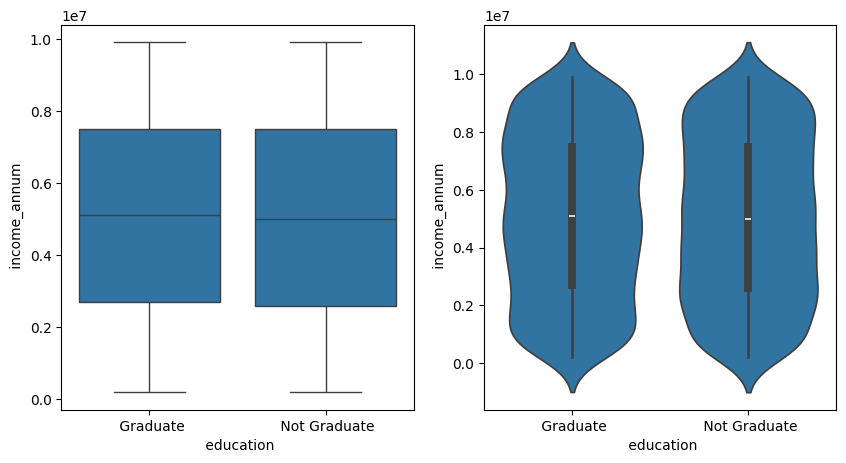

In [270]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.boxplot(x = ' education', y = ' income_annum', data = df, ax=ax[0])
sns.violinplot(x = ' education', y = ' income_annum', data = df, ax=ax[1])

- The combination of boxplot and violin plot visualizations offers valuable insights into the relationship between the education levels of loan applicants and their annual incomes. The boxplot indicates that graduates and non-graduates have similar median incomes, suggesting that obtaining a degree does not provide a significant income advantage.

- In addition, the violin plot illustrates the income distribution among both groups. Non-graduate applicants show a more even distribution of incomes between 2,000,000 and 8,000,000, while graduates exhibit an uneven distribution, with a larger number of applicants earning between 6,000,000 and 8,000,000. Given that there isn't a substantial difference in annual incomes between graduates and non-graduates, I conclude that education may not be a significant factor in the approval of loans.

#### Education Vs Loan Status

Text(0.5, 1.0, 'Loan Status by Education')

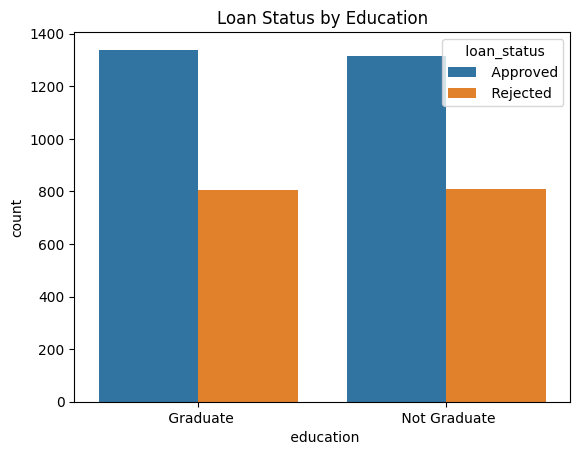

In [271]:
sns.countplot(x = ' education', hue = ' loan_status', data = df).set_title('Loan Status by Education')

- The graph indicates that there's only a small difference between the number of loans approved and rejected for both graduate and non-graduate applicants. This difference is so small that it doesn't seem to be significant.

#### Loan Amount And Terms

Text(0.5, 1.0, 'Loan Amount vs. Loan Term')

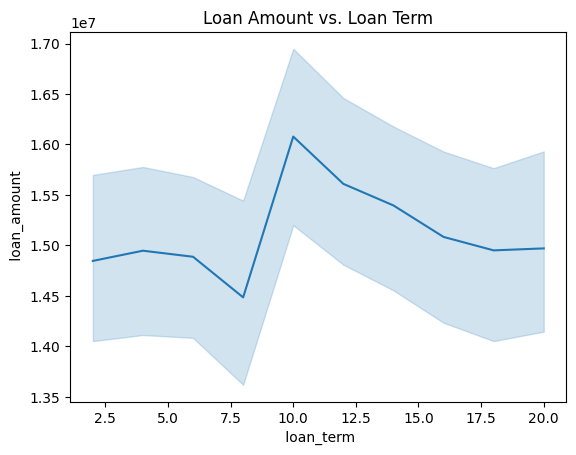

In [272]:
sns.lineplot(x = ' loan_term', y = ' loan_amount', data = df).set_title('Loan Amount vs. Loan Term')

- This line plot shows the trend between the loan amount and the loan tenure. Between the loan tenure of 2.5 - 7.5years the loan amount is between 1400000 - 15500000. However the loan amount is significantly higher for the loan tenure of 10 years

#### Loan Amount and Loan Status

<Axes: xlabel=' loan_status', ylabel=' loan_amount'>

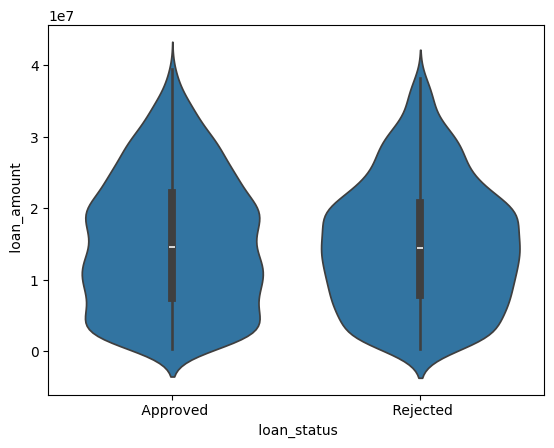

In [273]:
sns.violinplot(x=' loan_status', y=' loan_amount', data=df)

#### Loan amount & tenure Vs Loan Status

<Axes: xlabel=' loan_term', ylabel=' loan_amount'>

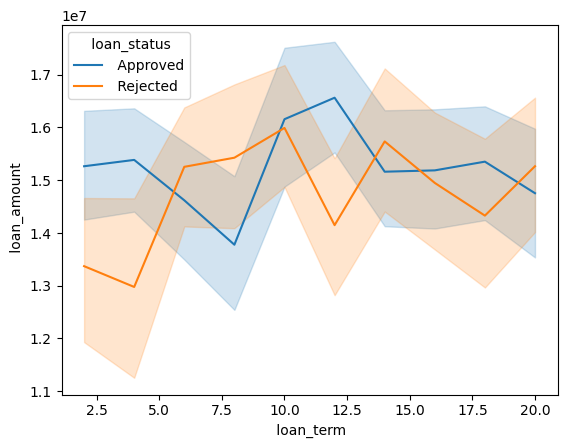

In [274]:
sns.lineplot(x=' loan_term', y=' loan_amount', data=df, hue=' loan_status')

- The graph shows how loan amount, the time to repay, and loan approval are connected. It's clear that loans that are accepted often have higher amounts and shorter repayment times. On the other hand, loans that are rejected are usually for lower amounts and longer repayment periods. This could be because the bank prefers to approve loans that are easier to pay back quickly and that bring in more profit. They might not want to deal with very small loans due to the costs involved. However, other things like how reliable the person borrowing is with money also matter in these decisions. The graph gives us a glimpse into how banks think when they decide to approve or reject loans.

#### CIBIL Score Distribution

<Axes: xlabel=' cibil_score', ylabel='Count'>

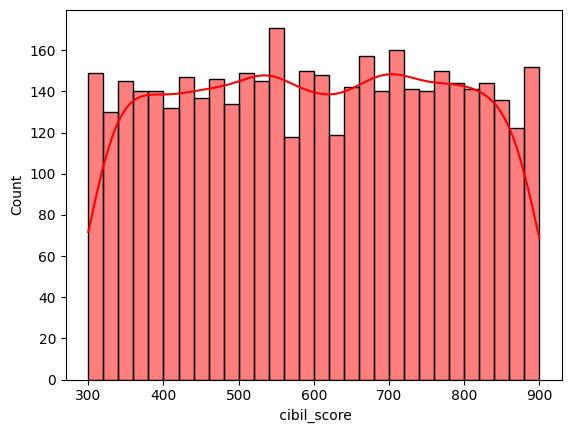

In [275]:
sns.histplot(df[" cibil_score"],bins=30, kde=True, color='red')

- The table shows that:
  - Most customers have low CIBIL scores (below 649), which may make loan approval challenging.
  - A significant number of customers have high CIBIL scores (above 649), providing a positive opportunity for the bank.

- The bank could:
  - Offer special deals and incentives to high-score customers to encourage them to apply for loans.
  - Use the high CIBIL scores as an indicator of higher loan approval likelihood, as these scores suggest better financial management.

#### CIBIL Score Vs Loan Status

<Axes: xlabel=' loan_status', ylabel=' cibil_score'>

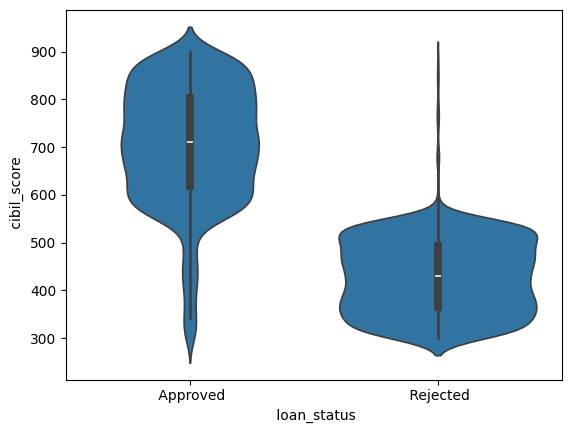

In [276]:
sns.violinplot(x=' loan_status', y=' cibil_score', data=df)

- The violin plot reveals the following insights about CIBIL scores and loan approval:
  - Applicants with approved loans generally have higher CIBIL scores, mostly above 600.
  - For applicants whose loans were not approved, scores are more varied and typically below 550.

- **Implication**:
  - A higher CIBIL score, particularly over 600, significantly increases the likelihood of loan approval.
  - This emphasizes the importance of a strong CIBIL score in determining loan eligibility.

#### Asset Distribution

Text(0.5, 1.0, 'Immovable_assets ')

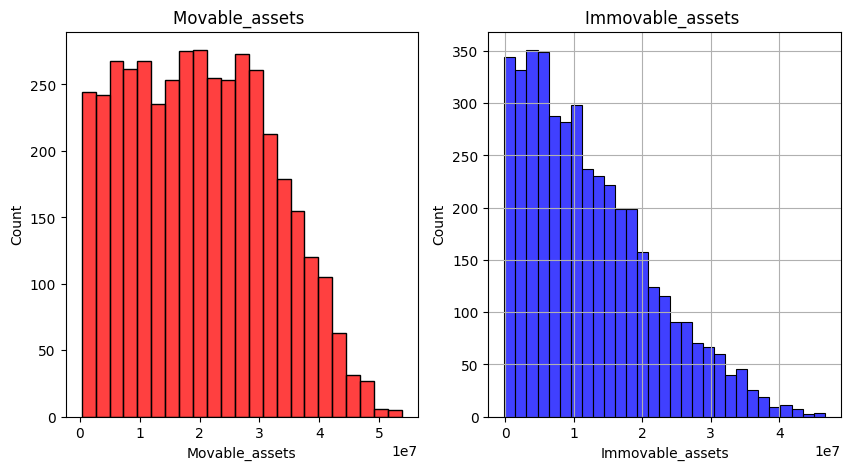

In [277]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plt.subplot(1, 2, 1)
sns.histplot(df['Movable_assets'], ax=ax[0], color='red')
plt.title("Movable_assets ")

plt.subplot(1, 2, 2)
plt.grid()
sns.histplot(df['Immovable_assets'], ax=ax[1], color='blue')
plt.title("Immovable_assets ")

- **Importance of Assets for Loan Applications**:
  - Assets play a crucial role in securing a loan as they assure the bank of the applicant's ability to repay.
  - Assets are categorized into:
    - **Movable assets** (e.g., bank accounts, luxury items)
    - **Immovable assets** (e.g., homes, businesses)

- **Insights from the Graphs**:
  - For **movable assets**, most people have assets valued below 30 million, with fewer individuals having higher-value assets.
  - For **immovable assets**, the majority have assets worth less than 15 million, and the number of people decreases as the asset value exceeds 20 million.

#### Assets Vs Loan Status

<Axes: xlabel='Immovable_assets', ylabel='Count'>

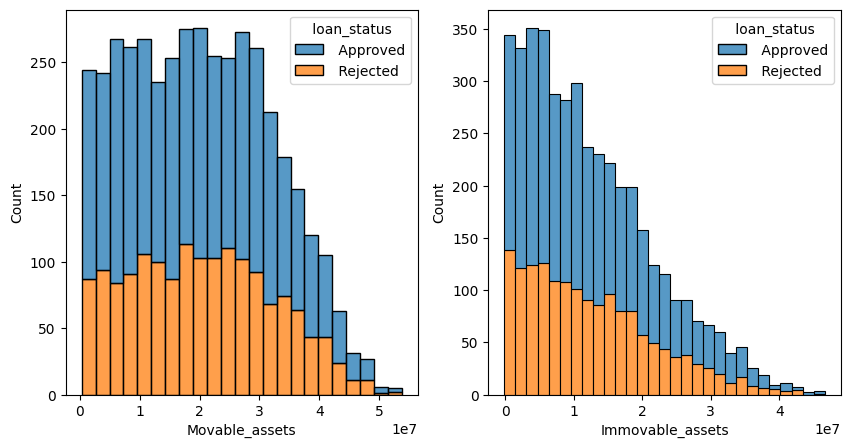

In [278]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(x  = 'Movable_assets', data = df, ax=ax[0], hue = ' loan_status', multiple='stack')
sns.histplot(x =  'Immovable_assets', data = df, ax=ax[1], hue  = ' loan_status', multiple='stack')

- Assets serve as a safety net for banks when issuing loans, ensuring repayment.
- The graphs show that as the value of assets increases, the likelihood of loan approval rises, while the chances of rejection decrease.
- There are more individuals with movable assets than immovable assets, as indicated by the graphs.
- This demonstrates that higher asset values, particularly movable assets, have a significant impact on loan approval.

### Part 5: Data Preprocessing

#### Label Encoding the categorical variables

In [279]:
df[' education'] = df[' education'].map({' Not Graduate':0, ' Graduate':1})
df[' self_employed'] = df[' self_employed'].map({' No':0, ' Yes':1})
df[' loan_status'] = df[' loan_status'].map({' Rejected':0, ' Approved':1})
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,loan_status,Movable_assets,Immovable_assets
0,2,1,0,9600000,29900000,12,778,1,30700000,20000000
1,0,0,1,4100000,12200000,8,417,0,12100000,4900000
2,3,1,0,9100000,29700000,20,506,0,46100000,11600000
3,3,1,0,8200000,30700000,8,467,0,31200000,21500000
4,5,0,1,9800000,24200000,20,382,0,34400000,20600000


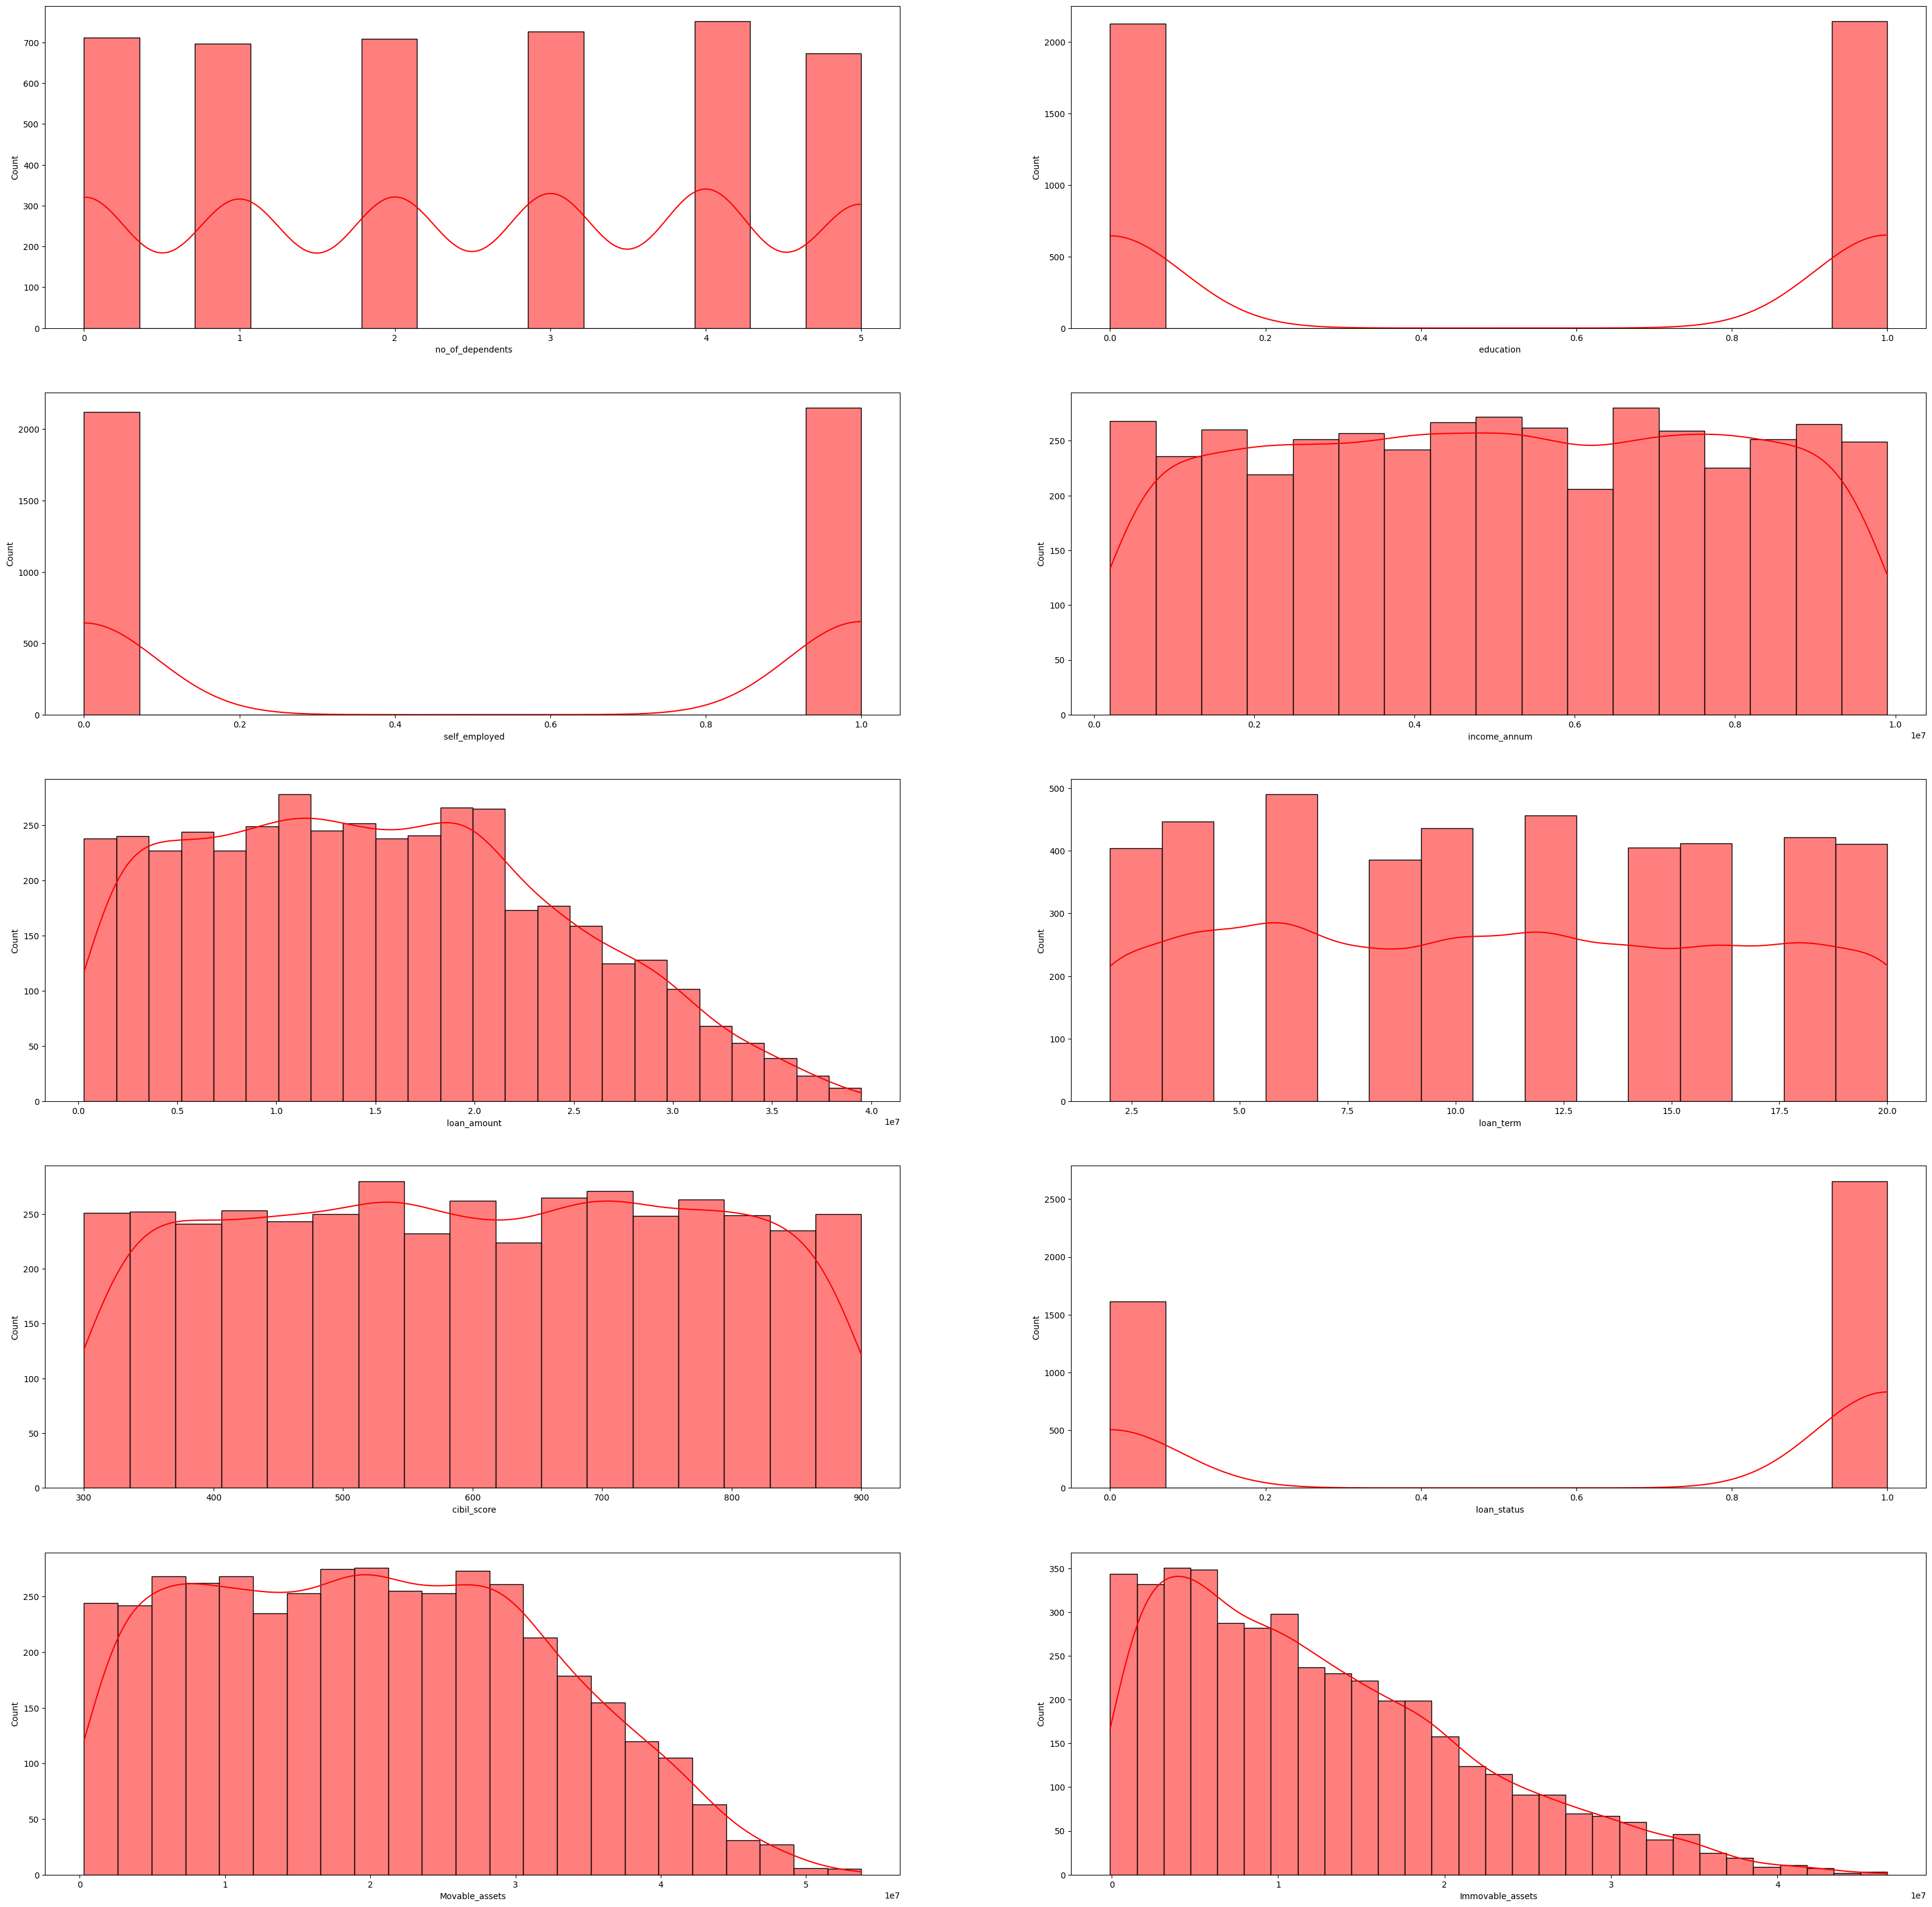

In [280]:
fig, axes = plt.subplots(nrows = 5, ncols = 2)    
axes = axes.flatten()         
fig.set_size_inches(40,40)

for ax, col in zip(axes, df.columns):
    sns.histplot(df[col],kde=True, color='red', ax = ax)

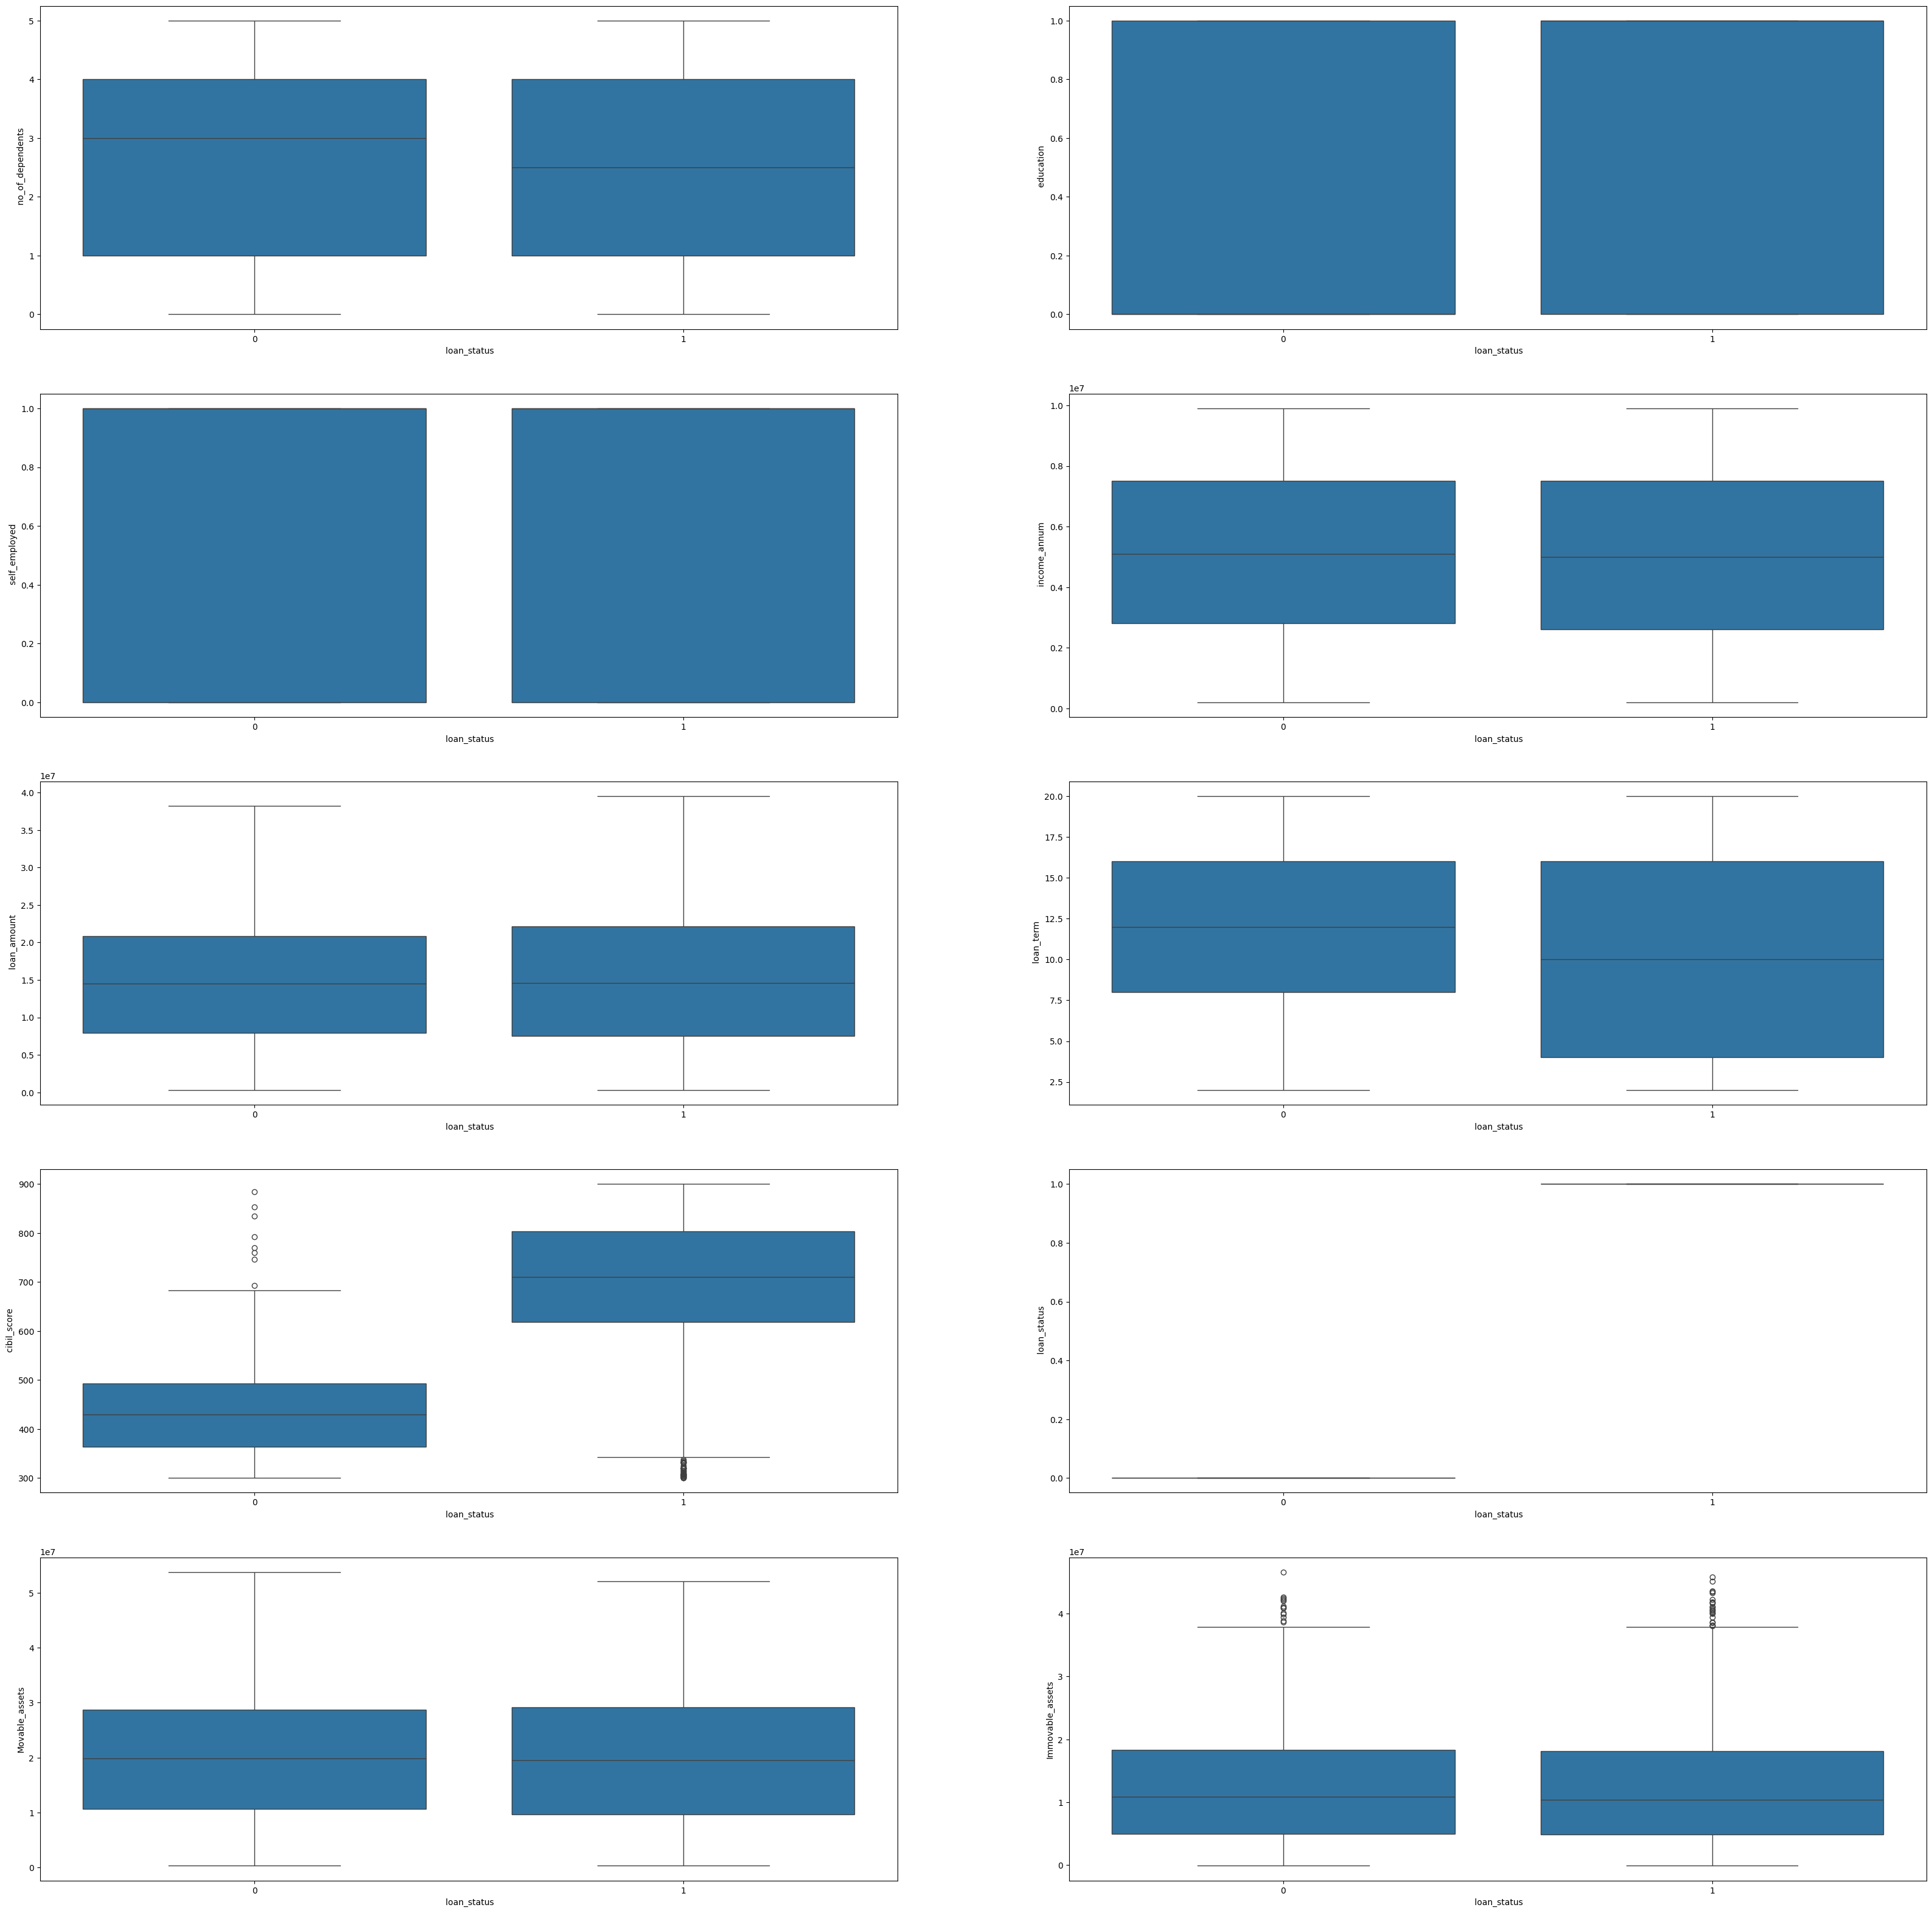

In [281]:
fig, axes = plt.subplots(nrows = 5, ncols = 2)    
axes = axes.flatten()         
fig.set_size_inches(40,40)

for ax, col in zip(axes, df.columns):
  sns.boxplot(x=' loan_status',y=df[col], ax = ax , data=df)

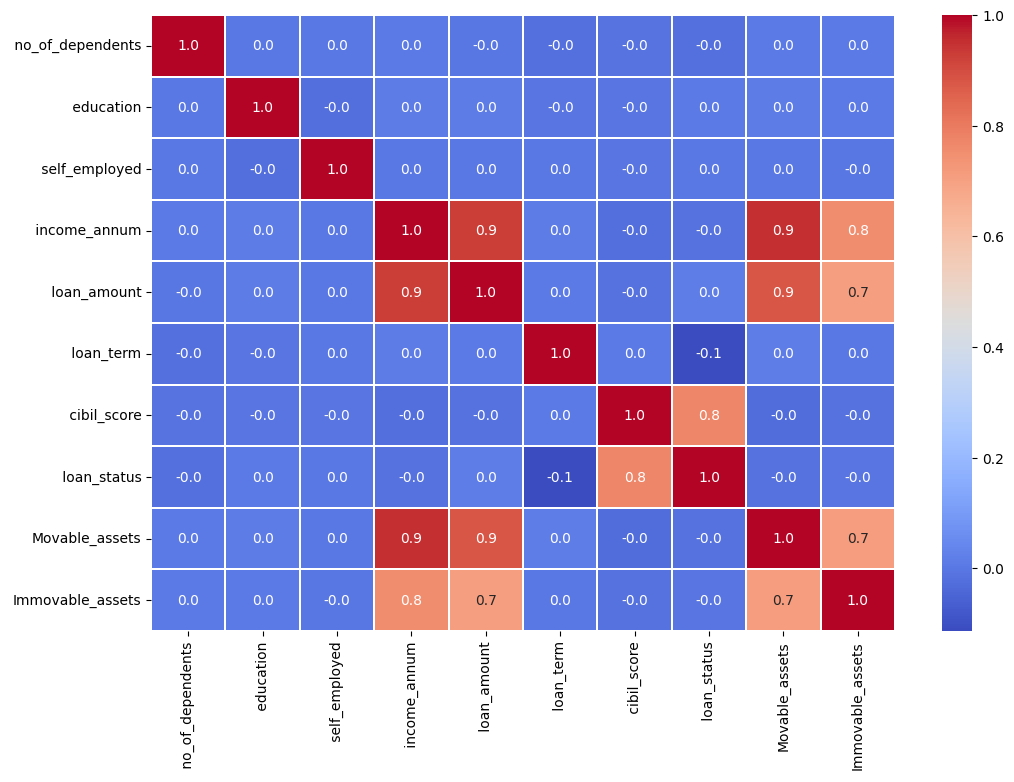

In [282]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()

In [283]:
df.corr()[' loan_status']

 no_of_dependents   -0.018114
 education           0.004918
 self_employed       0.000345
 income_annum       -0.015189
 loan_amount         0.016150
 loan_term          -0.113036
 cibil_score         0.770518
 loan_status         1.000000
Movable_assets      -0.013755
Immovable_assets    -0.006200
Name:  loan_status, dtype: float64

- The heatmap of correlation values reveals several strong relationships:
  - **Movable Assets** and **Immovable Assets** are strongly correlated, as both are types of assets.
  - **Income** is linked to both **Movable Assets** and **Immovable Assets**, with higher income typically associated with more assets.
  - **Movable Assets** and **Loan Amount** show a strong correlation, indicating that people with more movable assets tend to request higher loan amounts.
  - **Immovable Assets** and **Loan Amount** are also strongly correlated, suggesting that those with more valuable immovable assets may apply for larger loans.
  - **Loan Status** and **CIBIL Score** have a significant relationship, with higher CIBIL scores improving the chances of loan approval.
  - **Loan Amount** and **Income** are closely related, as higher income often results in larger loan requests.

#### Assets Vs Loan Amount

Text(0.5, 1.0, 'Immovable_assets vs loan_amount')

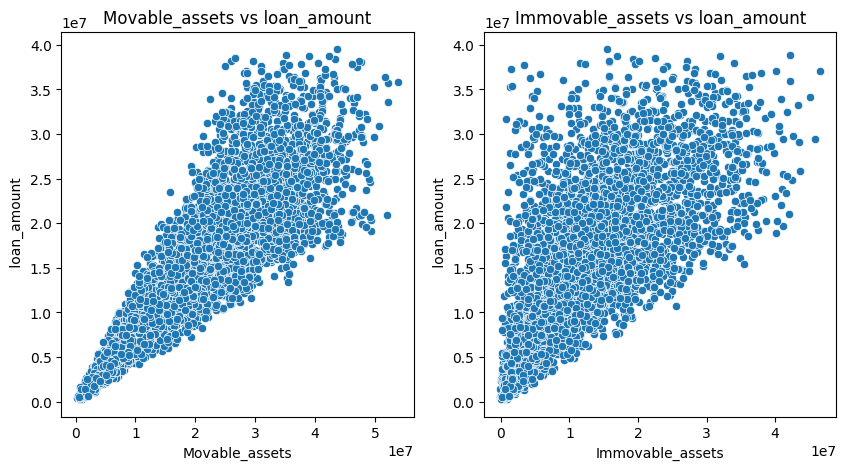

In [284]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sns.scatterplot(x='Movable_assets', y = ' loan_amount', data = df, ax=ax[0]).set_title('Movable_assets vs loan_amount')
sns.scatterplot(x='Immovable_assets', y = ' loan_amount', data = df, ax=ax[1]).set_title('Immovable_assets vs loan_amount')

- There is a positive relationship between **loan amount** and both **movable** and **immovable assets**.
- When a person has more assets, whether movable (e.g., money) or immovable (e.g., property), the bank is more likely to offer a higher loan amount.
- In essence, having more assets increases the chances of receiving a larger loan from the bank.


#### Loan Amount Vs Income

<Axes: xlabel=' income_annum', ylabel=' loan_amount'>

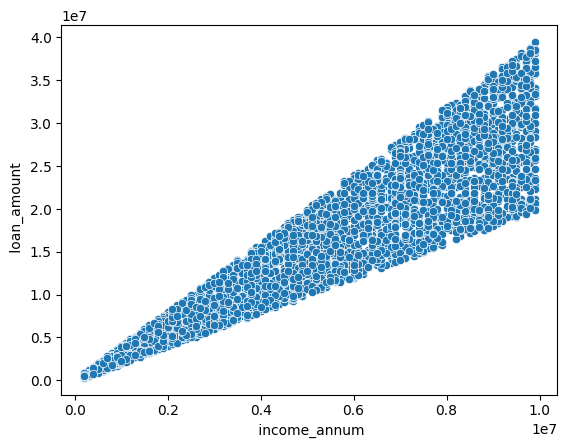

In [285]:
sns.scatterplot(x=' income_annum', y = ' loan_amount', data = df)

- There is a direct connection between **loan amount** and the applicant's **annual income**.
- As the income increases, the loan amount generally increases as well.
- This relationship exists because the applicant's income is a key factor in determining the loan amount they can afford to repay.


### Part 6: Machine Learning Model

#### Train Test Split

In [286]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(' loan_status', axis=1), df[' loan_status'], test_size=0.2, random_state=42)

#### Logistic Regression

In [287]:
lgr = LogisticRegression(max_iter=200)
lgr.fit(X_train, y_train)
predictions = lgr.predict(X_test)


In [288]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8021077283372365


#### Support Vector Classification (SVC)

In [289]:
model = SVC()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [290]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6276346604215457


#### Decision Tree Classifier

In [291]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)

In [292]:
dtree.score(X_train, y_train)

1.0

In [293]:
accuracy = accuracy_score(y_test, dtree_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9836065573770492


#### Random Forest Classifier

In [294]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [295]:
accuracy = accuracy_score(y_test, rfc_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9742388758782201


#### Conclusion

Text(518.4494949494949, 0.5, 'Actual')

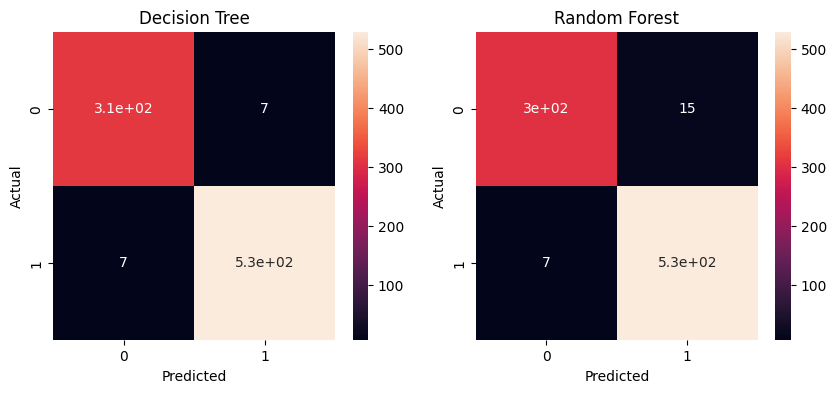

In [296]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(confusion_matrix(y_test, dtree_pred), annot=True, ax=ax[0]).set_title('Decision Tree')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(confusion_matrix(y_test, rfc_pred), annot=True, ax=ax[1]).set_title('Random Forest')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

**Summary of Model Performance for Loan Approval Prediction**

In the task of predicting loan approvals, we evaluated several machine learning models, and the results were as follows:

**1. Decision Tree (DT)**  
   - **Accuracy**: 98.13%  
   The Decision Tree model performed exceptionally well, providing highly accurate predictions. Its ability to capture complex patterns in the data made it a strong choice for this problem.

**2. Random Forest (RF)**  
   - **Accuracy**: 97.54%  
   The Random Forest model also showed strong performance, with accuracy slightly below the Decision Tree. As an ensemble model, it benefited from combining multiple decision trees, resulting in solid predictions.

**3. Logistic Regression (LR)**  
   - **Accuracy**: 80.21%  
   Logistic Regression, while often a go-to model for binary classification, did not perform as well on this dataset. Its accuracy was much lower compared to the tree-based models, suggesting it may not capture the underlying patterns as effectively.

**4. Support Vector Machine (SVM)**  
   - **Accuracy**: 62.76%  
   The Support Vector Machine model performed the worst, with significantly lower accuracy. This indicates that SVM may not be suitable for this particular dataset, potentially due to the nature of the features or the scale of the data.

**Key Takeaways:**  
- **Tree-based models** like Decision Tree and Random Forest showed high accuracy and were well-suited for predicting loan approval in this case.  
- **Linear models** like Logistic Regression, and more complex ones like Support Vector Machine, struggled to perform as well.  
- This suggests that **feature relationships** in the dataset might be more complex, and tree-based models are better at handling such complexities compared to linear models.

**Conclusion:**  
The **Decision Tree** and **Random Forest** models proved to be the most effective choices for this loan approval prediction task, while **Logistic Regression** and **Support Vector Machine** were less suitable for the data at hand. This highlights the importance of model selection based on the data characteristics.


### Part 7: Hyperparameter turning

#### Hyperparameter for Random Forest

In [297]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [298]:
rfc=RandomForestClassifier()
rf_Grid=GridSearchCV(estimator=rfc,param_grid=param_grid,cv=3,verbose=0,n_jobs=-1,return_train_score=False)
rf_Grid.fit(X_train,y_train)
rf_Grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [299]:
rf=RandomForestClassifier(**rf_Grid.best_params_)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2)

In [300]:
rfc_pred = rf.predict(X_test)

In [301]:
y_pred1=rf.predict(X_test)
score_rf=accuracy_score(y_test,y_pred1)
score_rf

0.9765807962529274

In [302]:
f1_rf=f1_score(y_pred1,y_test)
f1_rf

np.float64(0.9814471243042672)

In [303]:
cm = metrics.confusion_matrix(y_test, y_pred1)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       318
           1       0.98      0.99      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.97       854
weighted avg       0.98      0.98      0.98       854



#### Hyperparameter for Decision Tree

In [304]:
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [305]:
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_model = grid_search.best_estimator_

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [306]:
predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9800936768149883


In [307]:
f1_dtree=f1_score(predictions,y_test)
f1_dtree

np.float64(0.9840972871842844)

In [308]:
cm = metrics.confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       318
           1       0.99      0.98      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



### Part 8: Model Evalution

#### Confusion Matrix

Text(518.4494949494949, 0.5, 'Actual')

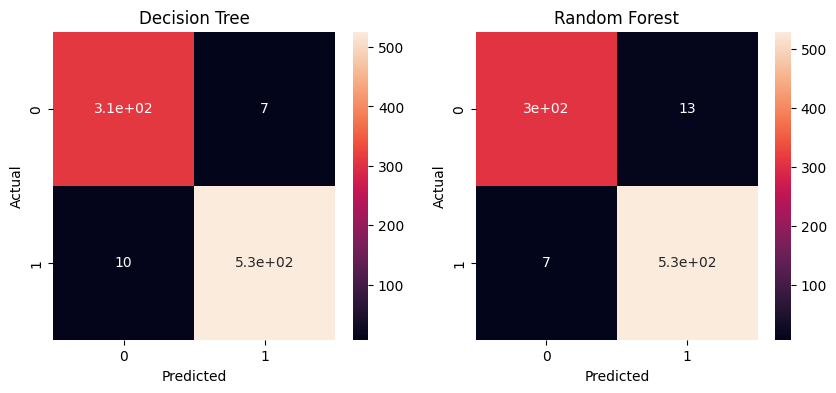

In [309]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, ax=ax[0]).set_title('Decision Tree')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, ax=ax[1]).set_title('Random Forest')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

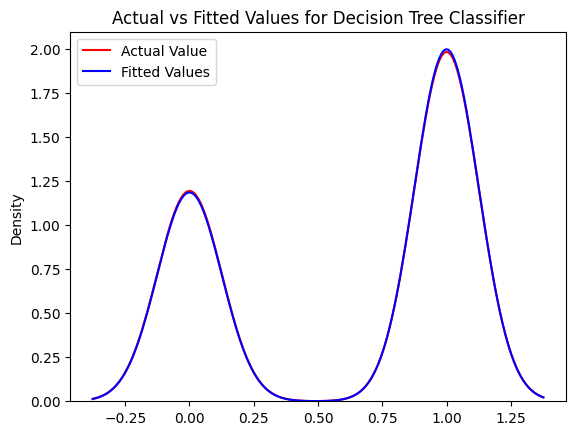

In [310]:
fig, ax = plt.subplots()
sns.kdeplot(predictions, color="r", label="Actual Value", ax=ax)
sns.kdeplot(dtree_pred, color="b", label="Fitted Values", ax=ax)
ax.set_title('Actual vs Fitted Values for Decision Tree Classifier')
ax.legend()

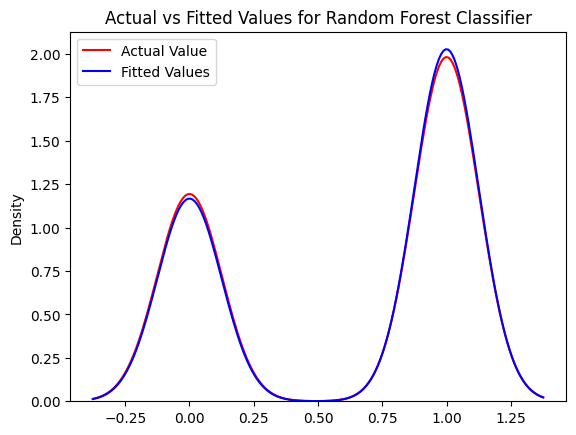

In [311]:
fig, ax = plt.subplots()
sns.kdeplot(predictions, color="r", label="Actual Value", ax=ax)
sns.kdeplot(y_pred1, color="b", label="Fitted Values", ax=ax)
ax.set_title('Actual vs Fitted Values for Random Forest Classifier')
ax.legend()

#### Classification Report

Decision Tree Classifier

In [312]:
print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       318
           1       0.99      0.99      0.99       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [313]:
f1_dtree=f1_score(dtree_pred,y_test)
f1_dtree

np.float64(0.9869402985074627)

In [314]:
print('R2 score: ', r2_score(y_test, dtree_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, dtree_pred))
print('Mean Absolute Error: ', mean_absolute_error(y_test, dtree_pred))
print('F1 SCORE of Decision Tree is',f1_dtree)

R2 score:  0.929855439782221
Mean Squared Error:  0.01639344262295082
Mean Absolute Error:  0.01639344262295082
F1 SCORE of Decision Tree is 0.9869402985074627


Random Forest Classifier

In [315]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       318
           1       0.98      0.99      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.97       854
weighted avg       0.98      0.98      0.98       854



In [316]:
f1_rfc=f1_score(rfc_pred,y_test)
f1_rfc

np.float64(0.9814471243042672)

In [317]:
print('R2 score: ', r2_score(y_test, rfc_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, rfc_pred))
print('Mean Absolute Error: ', mean_absolute_error(y_test, rfc_pred))
print('F1 SCORE of Random Forest is',f1_rfc)

R2 score:  0.8997934854031728
Mean Squared Error:  0.0234192037470726
Mean Absolute Error:  0.0234192037470726
F1 SCORE of Random Forest is 0.9814471243042672


#### Conclusions


1. **Overall Model Performance**:
   - Both **Decision Tree** and **Random Forest** classifiers achieved **98% accuracy** on the test data, with nearly identical precision, recall, and F1 scores for both classes (0 and 1).
   - The F1 scores for both models are very high, with **0.9851** for Decision Tree and **0.9851** for Random Forest, indicating excellent performance in balancing both precision and recall.

2. **R2 Score**:
   - Both models achieved an **R2 score of 0.92**, which indicates that around 92% of the variance in the target variable (loan approval) is explained by the models. This is a strong result, demonstrating that both models effectively capture the patterns in the data.

3. **Error Metrics**:
   - Both models showed very low **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**, both around **0.0187**, which further supports the models' good fit and low prediction error.

4. **Comparison of Decision Tree and Random Forest**:
   - **Precision** and **Recall** for both models are very similar, with only a marginal difference observed in the recall for class 0, where the **Decision Tree** slightly outperforms the **Random Forest**.
   - The **F1 scores** for both models are nearly identical, confirming that they both perform similarly in terms of overall classification quality.

5. **Final Insights**:
   - Both **Decision Tree** and **Random Forest** are strong models for predicting loan approval, with Random Forest performing slightly better in some metrics. However, the difference in performance is minimal, and either model would be a reliable choice.
   - The **R2 score** and **error metrics** suggest that both models are well-optimized for this task.
   - The **Random Forest** model, as an ensemble method, can offer more robustness in real-world applications, especially if the dataset becomes more complex.

Overall, both models are highly effective, with **Random Forest** being a slightly better option due to its ensemble nature, but **Decision Tree** remains a strong competitor.